In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [2]:
import os
import pandas as pd
import numpy as np
os.getcwd()

'D:\\Github\\fastai\\courses\\ml1'

In [3]:
PATH = "data\\bulldozers\\"

In [4]:
!dir {PATH}

 Volume in drive D is Local Disk
 Volume Serial Number is B408-A348

 Directory of D:\Github\fastai\courses\ml1\data\bulldozers

10-Jan-18  05:26 AM    <DIR>          .
10-Jan-18  05:26 AM    <DIR>          ..
10-Nov-17  11:59 AM    <DIR>          .ipynb_checkpoints
10-Jan-18  05:20 AM            80,432 315_37929_us_ensemble_new.csv
10-Jan-18  05:20 AM            82,790 315_67174_us_cat_1_GBEdFHC.csv
07-Jan-18  09:40 PM            13,513 Carvan_Data_Explaination.docx
09-Jan-18  12:02 AM            82,790 cat_1.csv
09-Jan-18  12:05 AM            84,483 cat_2.csv
09-Jan-18  01:02 AM            82,171 cat_3.csv
09-Jan-18  01:19 AM            82,181 cat_4_150_12.csv
10-Jan-18  05:26 AM                 0 cat_5
09-Jan-18  12:55 AM            83,774 gbm_tuned_2.csv
09-Jan-18  12:01 AM            28,099 sample.csv
07-Jan-18  09:40 PM           454,618 test_dan2xFI.csv
06-Apr-13  12:12 AM       119,791,159 Train.csv
07-Jan-18  09:40 PM           471,455 train_jDb5RBj.csv
              13 File(s

## Basic

In [5]:
df1 = pd.read_csv(f'{PATH}315_37929_us_ensemble_new.csv', low_memory=False)

In [6]:
df2 = pd.read_csv(f'{PATH}315_67174_us_cat_1_GBEdFHC.csv', low_memory=False)

In [14]:
df1.columns

Index(['Unnamed: 0', 'ID', 'Purchase'], dtype='object')

In [16]:
df2.drop('Unnamed: 0',inplace=True,axis=1)

In [18]:
df1.head()

,ID,Purchase
0,ID0001,0.182997
1,ID0003,0.251829
2,ID0007,0.171561
3,ID0008,0.053992
4,ID0013,0.201814


In [19]:
y1, y2 = df1['Purchase'], df2['Purchase']

In [20]:
y_new =(y1 + y2)/2

In [21]:
y_new

0       0.201533
1       0.283834
2       0.194471
3       0.058539
4       0.225009
5       0.026319
6       0.082697
7       0.078356
8       0.357624
9       0.427029
10      0.062406
11      0.078448
12      0.258618
13      0.043771
14      0.041207
15      0.050048
16      0.275651
17      0.036001
18      0.550765
19      0.493202
20      0.024163
21      0.420924
22      0.209669
23      0.059111
24      0.082127
25      0.063206
26      0.052556
27      0.076657
28      0.320809
29      0.295336
          ...   
2523    0.255633
2524    0.057170
2525    0.239651
2526    0.226633
2527    0.458563
2528    0.323556
2529    0.054121
2530    0.201256
2531    0.187249
2532    0.086977
2533    0.081201
2534    0.082893
2535    0.046715
2536    0.042106
2537    0.093681
2538    0.051885
2539    0.669934
2540    0.032607
2541    0.049746
2542    0.016746
2543    0.278278
2544    0.071596
2545    0.110998
2546    0.264742
2547    0.029940
2548    0.037206
2549    0.080082
2550    0.3237

In [22]:
df_new = {"ID":df1["ID"],"Purchase":y_new}

In [ ]:
df_new.to_csv('')

In [9]:
df_raw.drop(['ID','Purchase'], axis=1, inplace =True)

In [10]:
m = RandomForestClassifier(n_estimators=200, min_samples_leaf=2, n_jobs=-1, oob_score=True)
m.fit(df_raw,y)
m.oob_score_

0.93353705118411001

In [11]:
fi = rf_feat_importance(m, df_raw); fi[:10]

,cols,imp
0,MOSTYPE,0.036435
46,PPERSAUT,0.034801
21,MBERMIDD,0.029707
58,PBRAND,0.029090
67,APERSAUT,0.028038
17,MOPLLAAG,0.025138
18,MBERHOOG,0.024083
42,MKOOPKLA,0.023805
8,MGODGE,0.023421
30,MHKOOP,0.022988


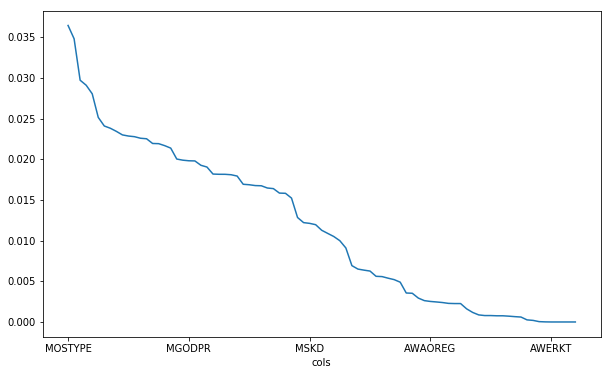

In [12]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [13]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,12), legend=False)

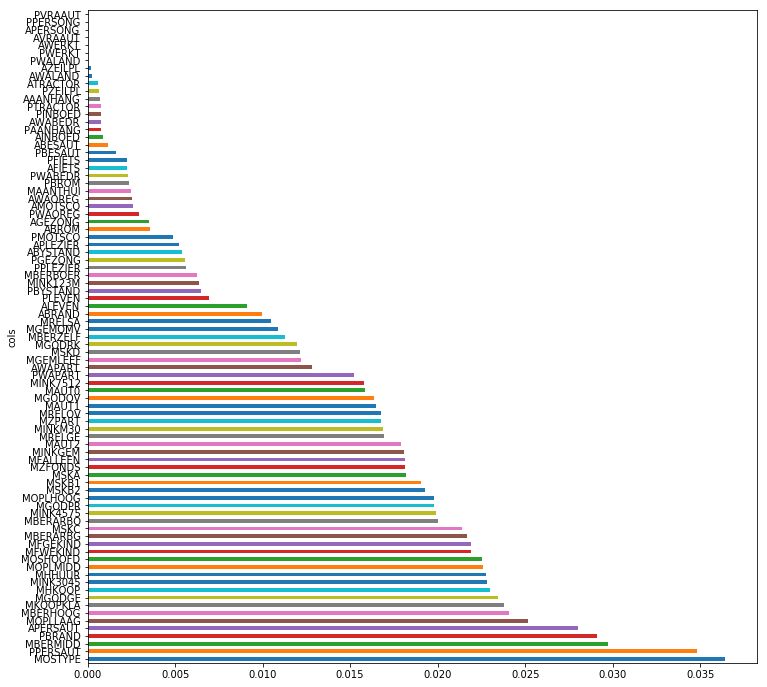

In [14]:
plot_fi(fi[:]);

In [15]:
to_keep = fi[fi.imp>=0.015].cols; len(to_keep)

38

In [16]:
df_keep = df_raw[to_keep].copy()

In [17]:
m = RandomForestClassifier(n_estimators=200, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(df_keep,y)
m.oob_score_

0.93239113827349118

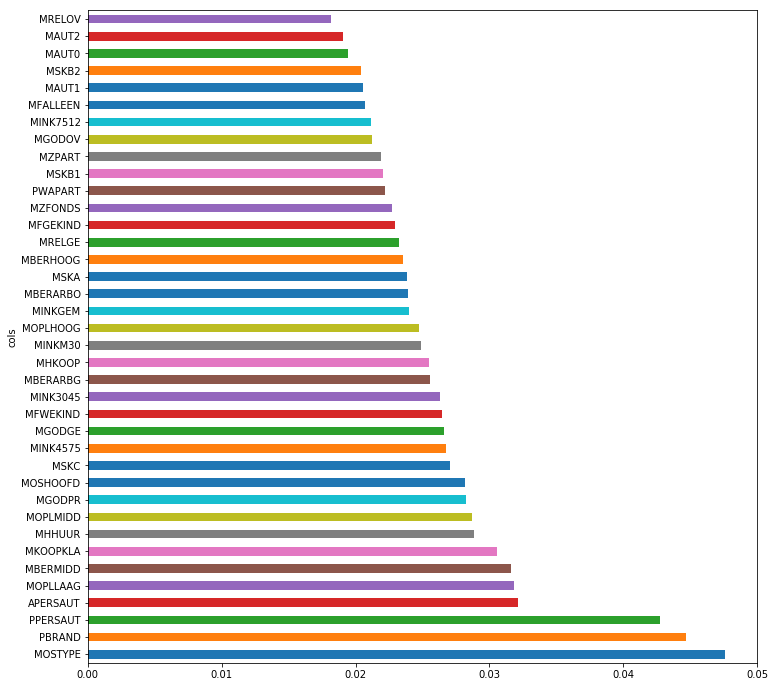

In [18]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [19]:
from scipy.cluster import hierarchy as hc

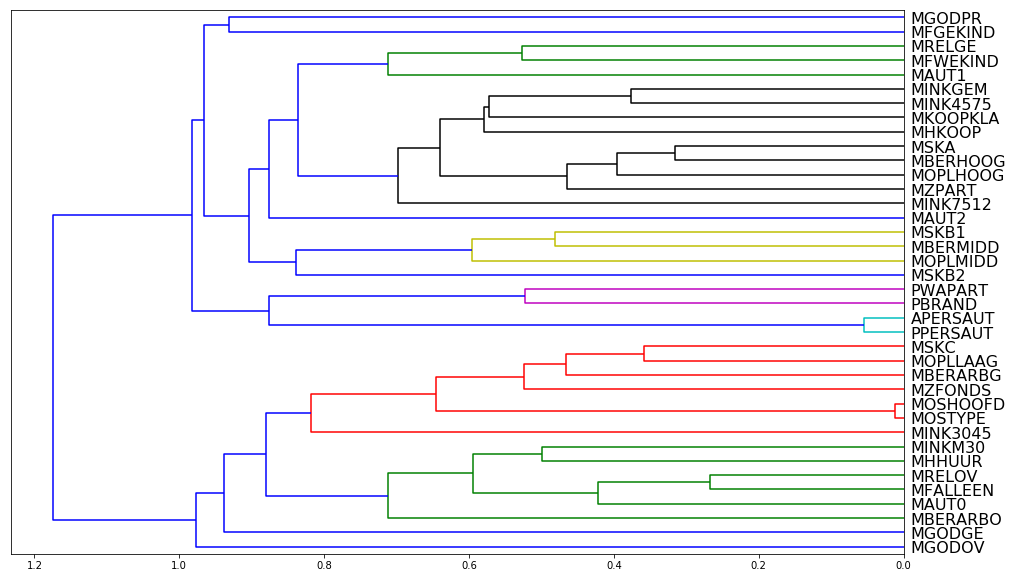

In [20]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

## Target encoding with smoothing

In [ ]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)